In [4]:
import networkx as nx
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Pool
from anytree import Node, RenderTree, Walker, Resolver
from anytree.dotexport import RenderTreeGraph

In [5]:
def partitions(nodes, n):
    #Partition the nodes into n subsets
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter, n))
        if not partition:
            return
        yield partition

In [6]:
def between_parallel(G, processes=None):
    # Initialize Pool obj w/# of available processors
    # Partition network based on size of Pool obj
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
    
    bet_map = p.map(btwn_pool, zip([G]*num_partitions, [True]*num_partitions, [None]*num_partitions, node_partitions))
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
            
    return bt_c


In [9]:
class SimNetwork:
    '''
    H: # of social positions w/in each dimension
    D: # of dimensions in society (complexity)
    G: # of people located in each social position
    N: population size = H * G
    '''            
    def __init__(self, H, D, G, Z, alpha=1, beta=1, treeType="binary"):
        self.H = H
        self.D = D
        self.G = G
        self.N = G * H
        self.Z = Z
        self.alpha=alpha
        self.beta = beta
        self.options = None
        self.norm_const = None
        self.norm_const_alpha = None
        self.treeType = treeType
        self.root = Node("root") if treeType == "other" else None
        self.treeNodes = {} if treeType =="other" else None
        self.distanceMatrix = self.generateDistanceMatrix()
        self.socialPositionMatrix = self.generateSocPosMatrix()
        self.newPeople = None
        self.socialDistanceMatrix = self.generateSocDistMatrix()
        self.adjacencyMatrix = self.generateTies()
        
    '''
        Getters & Helper Functions
    '''
    def getHeterogeneity(self):
        return self.H
    def getComplexity(self):
        return self.D
    def getGroupSize(self):
        return self.G
    def getPopulationSize(self):
        return self.N
    def getTreeType(self):
        return self.treeType
    def getDistanceMatrix(self):
        return self.distanceMatrix
    def getSocialPositionMatrix(self):
        return self.socialPositionMatrix
    def getSocialDistanceMatrix(self):
        return self.socialDistanceMatrix
    def getSocialTies(self):
        return self.adjacencyMatrix
    def getNewComers(self):
        return self.newPeople
    def printTree(self):
        print(RenderTree(self.root))
    
    ''' 
        Assuming Binary-Tree-Like distance between root nodes
        Distance of 1 when i & j are in same social position
    '''
    def distance(self,H,i, j,):
        numLevels = np.log2(H)+1 # max steps to root based on binary tree assumption
        if min(i,j) <= H/2 and max(i,j) > H/2:
            return numLevels
        else:
            return self.distance(H/2, ((i-1)%(H/2))+1,((j-1)%(H/2))+1)
    
    def findLeastCommonAncestor(self,n1,n2):
        path1 = (n1.path)[::-1]
        path2 = (n2.path)[::-1]
        
        common = [x for x in range(len(path1)) if path1[x] in path2]
        return(min(common)+1)
        
    
    def generateTreeFromFile(self,file):
        try:
            with open(file) as f:
                    numLevels = int(f.readline())
                    data = {}
                    for i in range(numLevels):
                        print("Reading Level [%d] nodes "% (numLevels-i))
                        levelData = f.readline().strip().split(" ")
                        node_data = []
                        for j in range(len(levelData)):
                            nodes = levelData[j]
                            node_data.append(nodes[nodes.find("[")+1:nodes.find("]")].split(","))

                        data[str(numLevels-i)] = node_data

                    for key in data:
                        for arr in data[key]:
                            if int(key) == numLevels: # at level where parent is root
                                for i in range(len(arr)):
                                    self.treeNodes[key+str(i+1)] = Node(key+str(i+1), parent=self.root)
                            else:
                                for element in range(len(arr)):
                                    p = str(int(key) + 1)+str(data[key].index(arr)+1)
                                    self.treeNodes[key+str(arr[element])] = Node(key+str(arr[element]), parent=self.treeNodes[p])
        except:
            print("Unable to read file given")
            nFile = input("Provide new file name: ")
            self.generateTreeFromFile(nFile)
        
        
    def generateDistanceMatrix(self):
        start_time = time.time()
        print ("Generating Distance Matrix...")
        matrix = np.ones((self.H,self.H)) # min dist val = 1 i.e. distance to self = 1
        if self.treeType == 'binary':
            for i in range(1,self.H+1):
                for j in range(1,self.H+1):
                    if i != j:
                        matrix[i-1,j-1] = self.distance(self.H,i,j)
        else:
            '''
            read from supplied txt file with following format:
            [n=NumberofLevels(not including root)]
            [Nodes in group 1, level n] [Nodes in group 2, level n] ... [Nodes in group n, level n]
            ...
            [Nodes in group 1, level 1]...
            '''
            file = input('Enter file to read from: ')
            self.generateTreeFromFile(file)
            RenderTreeGraph(self.root).to_picture("graph.png")            
                
            # now w/tree can calculate distances btwn leaf nodes
            leafNodes = {k: v for k, v in self.treeNodes.items() if k.startswith('1')}
            leaf_names = [int(x)%10 for x in list(leafNodes.keys())]
            for key,val in leafNodes.items():
                # first find immediate siblings and assign distance of 2
                idi = int(key)%10
                sibs = val.siblings
                lst_explored = [idi]
                for sib in sibs:
                    idj = int(sib.name) % 10
                    matrix[idi-1,idj-1] = 2
                    lst_explored.append(idj)
                
                # calculate distances to remaining leaf nodes
                to_explore = [x for x in leaf_names if int(x) not in lst_explored]
                for n in to_explore:
                    matrix[idi-1,n-1] = self.findLeastCommonAncestor(val,leafNodes[str(n+10)])
                    
                
        print("Distance Matrix: [Complete]")
        print("Time to Completion: %s seconds" % (time.time() - start_time))
        return matrix
    
    
    def fillPositionMatrix(self, positions):
        for i in range(self.N):
            for j in range(1,self.D):
                dis = np.random.choice(self.options, 1, p=self.norm_const*np.exp(-self.options*self.beta))
                temp = self.distanceMatrix[int(positions[i,0]-1),:]
                idx = [x for x in range(len(temp)) if temp[x] <= dis]
                idx = [x+1 for x in idx]
                if len(idx) == 1:
                    positions[i,j] = idx[0]
                else:
                    positions[i,j] = np.random.choice(idx,1)
        
        return positions
    
    def updateSocPosMatrix(self):
        for i in self.newPeople:
            for j in range(1,self.D):
                dis = np.random.choice(self.options, 1, p=self.norm_const*np.exp(-self.options*self.beta))
                temp = self.distanceMatrix[int(self.socialPositionMatrix[i,0]-1),:]
                idx = [x for x in range(len(temp)) if temp[x] <= dis]
                idx = [x+1 for x in idx]
                if len(idx) == 1:
                    self.socialPositionMatrix[i,j] = idx[0]
                else:
                    self.socialPositionMatrix[i,j] = np.random.choice(idx,1)
            
    
    def generateSocPosMatrix(self):
        start_time = time.time()
        print("Generating Social Positions Matrix...")
        positions = np.zeros((self.N, self.D))
        positions[:,0] = np.random.choice(np.arange(1,self.H+1),size=self.N)
        self.options = np.arange(1, np.log2(self.H)+2)
        self.norm_const = 1/sum(np.exp(-self.options*self.beta))
        print("Social Position Matrix: [Complete]")
        print("Time to Completion: %s seconds" % (time.time() - start_time))

        return self.fillPositionMatrix(positions)
               
    '''
    Function to simulate removal of random individuals
    '''
    def removeFromSocPosMatrix(self, newProportion):
        newNum = round(newProportion*self.N)
        self.newPeople = np.random.choice(self.N, newNum)
        
        self.socialPositionMatrix[self.newPeople,:] = 0
        self.socialPositionMatrix[self.newPeople,0] = np.random.choice(np.arange(1,self.H+1), newNum)
        self.updateSocPosMatrix()
        
    def generateSocDistMatrix(self):
        start_time = time.time()
        print("Generating Social Distance Matrix...")
        socialDist = np.zeros((self.N,self.N))
        # O(n^2)
        for i in range(self.N):
            for j in range(self.N):
                if i > j:
                    arr1 = self.socialPositionMatrix[i,:].astype(int)
                    arr1 = [x-1 for x in arr1]
                    arr2 = self.socialPositionMatrix[j,:].astype(int)
                    arr2 = [x-1 for x in arr2]
                    temp_diag = (np.diag(self.distanceMatrix[arr1, arr2])).diagonal()
                    socialDist[i,j] = min(temp_diag)
                    socialDist[j,i] = socialDist[i,j]
        
        print("Social Distance Matrix: [Complete]")
        print("Time to Completion: %s seconds" % (time.time() - start_time))

        return socialDist
    
    def fillAdjMatrix(self, adjMatrix, degCounts, complete):
        prevDegCounts = degCounts
        counter = 0
        maxCounter = 1000
        i = None
        while sum(complete) < self.N:
            if complete.count(False) > 1:
                i = np.random.choice([x for x in range(len(complete)) if complete[x] == False],1) # random person
            elif complete.count(False) == 1:
                for idx in range(len(complete)):
                    if complete[idx] == False:
                        i = idx
                        break
                
            distConstraint = np.random.choice(self.options, 1, p=self.norm_const_alpha*np.exp(-self.options*self.alpha))
            temp = self.socialDistanceMatrix[i,:].astype(int)
            optj = np.where(temp < distConstraint)
            if len(optj) == 2:
                optj = optj[1]
            else:
                optj = optj[0]
            if i in optj:
                optj = optj[optj != i]
            if len(optj) > 1: # several friend options
                newTie = np.random.choice(optj, 1)
                adjMatrix[i,newTie] = 1 # friend
                adjMatrix[newTie,i] = 1
                degCounts[i] = degCounts[i] + 1
                degCounts[newTie] = degCounts[newTie]+1
            
            elif len(optj == 1):
                newTie = optj[0]
                adjMatrix[i,newTie] = 1
                adjMatrix[newTie,i] = 1
                degCounts[i] = degCounts[i] + 1
                degCounts[newTie] = degCounts[newTie]+1
            
            complete = (degCounts >= self.Z).tolist()
            
            if (np.all(prevDegCounts == degCounts)):
                counter = counter + 1
            
            prevDegCounts = degCounts
            if counter > maxCounter:
                break
        
        return adjMatrix
    
    def generateTies(self):
        start_time = time.time()
        print("Generating friendships...")
        self.norm_const_alpha = 1/sum(np.exp(-self.options*self.alpha))
        adjMatrix = np.zeros((self.N, self.N))
        degCounts = np.zeros(self.N)
        complete = [False] * self.N
        print("Friendships: [Complete]")
        print("Time to Completion: %s seconds" % (time.time() - start_time))
        return self.fillAdjMatrix(adjMatrix, degCounts, complete)
        
    
    def generateTiesWithNewcomers(self, newPeople):
        start_time = time.time()
        print("Generating new ties...")
        self.adjacencyMatrix[newPeople,:] = 0
        self.adjacencyMatrix[:,newPeople] = 0
        
        degCounts = np.sum(self.adjacencyMatrix, axis=1)        
        complete = (degCounts >= self.Z).tolist()
        updatedMat = self.fillAdjMatrix(self.adjacencyMatrix, degCounts, complete)
        self.adjacencyMatrix = updatedMat
        print("New Ties: [Complete]")
        print("Time to Completion: %s seconds" % (time.time() - start_time))
        
    def makeNetwork(self):
        print("Beginning to draw network...")
        m = np.asmatrix(self.adjacencyMatrix)
        G = nx.from_numpy_matrix(m)
        nx.draw_networkx(G, node_color='blue', font_color='white')
        plt.show()
    
             

Generating Distance Matrix...
Distance Matrix: [Complete]
Time to Completion: 0.016661882400512695 seconds
Generating Social Positions Matrix...
Social Position Matrix: [Complete]
Time to Completion: 0.0009360313415527344 seconds
Generating Social Distance Matrix...
Social Distance Matrix: [Complete]
Time to Completion: 77.7617437839508 seconds
Generating friendships...
Friendships: [Complete]
Time to Completion: 0.0006470680236816406 seconds
Total Matrix Creation Exec Time: 81.20691418647766 seconds
Beginning to draw network...


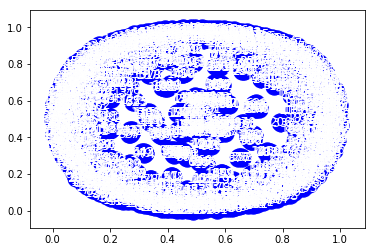

Network Graphing from Adjacency Matrix: 35.939605951309204 seconds
Generating new ties...
New Ties: [Complete]
Time to Completion: 0.8550679683685303 seconds
Beginning to draw network...


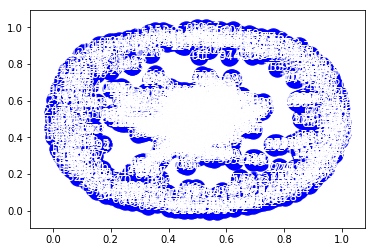

Network Graphing from Adjacency Matrix w/New Comers: 35.71475315093994 seconds


In [10]:
if __name__ == "__main__":
    start_time = time.time()
    sn = SimNetwork(H=32, D=10, G=50, Z=10,alpha=.5,beta=.5)
    print("Total Matrix Creation Exec Time: %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    sn.makeNetwork()
    print("Network Graphing from Adjacency Matrix: %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    sn.generateTiesWithNewcomers([5,10,20])
    sn.makeNetwork()
    print("Network Graphing from Adjacency Matrix w/New Comers: %s seconds" % (time.time() - start_time))
